# Mental Health and Psychological Distress
**study on medical student mental health: burnout, empathy, anxiety, and depression**

This workbook is to analyze how different factors might be related to psychological distress. Study is based on data on medical students' mental health in Switzerland: demographic information, self-reported health status, psychological tests results, and survey responses.

Workbook contains:
- [Data Exploration](#eda)
- [Data Preparation](#prepare-data)
- [Data Modeling](#data-modeling)
- [Evaluate the Results / Summary](#summary)

Data can be downloaded from Kaggle: https://www.kaggle.com/datasets/thedevastator/medical-student-mental-health.

https://zenodo.org/record/5702895#.ZBGZEpHMIuV

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action = 'ignore')

from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance
import shap

from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [2]:
df = pd.read_csv(r'data\Data_MedTeach.csv', header=0)
df.head()

,id,age,year,sex,glang,part,job,stud_h,health,psyt,jspe,qcae_cog,qcae_aff,amsp,erec_mean,cesd,stai_t,mbi_ex,mbi_cy,mbi_ea
0,2,18,1,1,120,1,0,56,3,0,88,62,27,17,0.738095,34,61,17,13,20
1,4,26,4,1,1,1,0,20,4,0,109,55,37,22,0.690476,7,33,14,11,26
2,9,21,3,2,1,0,0,36,3,0,106,64,39,17,0.690476,25,73,24,7,23
3,10,21,2,2,1,0,1,51,5,0,101,52,33,18,0.833333,17,48,16,10,21
4,13,21,3,1,1,1,0,22,4,0,102,58,28,21,0.690476,14,46,22,14,23


In [3]:
df.shape

(886, 20)

## Data Exploration<a id='eda'></a>

Dataset has the follwing columns (we rename some of them):

* id: Participant's ID.
* age: Age of the participant
* year: Year of study of the participant
* sex: Gender of the participant. Q: To which gender do you identify the most ? 1=Man; 2=Woman; 3=Non-binary
* glang (_language_): Language spoken by the participant.
* part (_partnership_): Partnership status. Q: Do you have a partner?; 0=No; 1=Yes
* job: Job of the participant. Q: Do you have a paid job?; 0=No; 1=Yes
* stud_h (_stydy_h_): Hours of study per week of the participant. Q: How many hours per week do you study on top of courses?
* health: Self-reported health status of the participant. Q:  How satisfied are you with your health?; 1=Verydissatisfied to 5=Verysatisfied
* psyt (_psychological_distress_): Psychological distress score of the participant. Q: During the last 12 months have you ever consulted a psychotherapist or a psychiatrist for your health?;0=No; 1=Yes
* jspe(_job_satisfaction_): Job satisfaction score of the participant. (Integer)
* qcae_cog (_cognitive_emphaty_): Cognitive empathy score of the participant. (Integer)
* qcae_aff (_affective_emphaty_): Affective empathy score of the participant. (Integer)
* amsp (_academic_motivation_): Academic motivation score of the participant. (Integer)
* erec_mean (_mean_empathy_): Empathy rating score mean of the participant. (Integer)
* cesd (_depression_): Center for Epidemiologic Studies Depression scale of the participant. (Integer)
* stai_t (_anxiety_): State-Trait Anxiety Inventory scale of the participant. (Integer)
* mbi_ex (_exhaustion_): Maslach Burnout Inventory-Exhaustion scale of the participant. (Integer)
* mbi_cy (_cynicism_): Maslach Burnout Inventory - Cynicism Scale of the participant. (Integer)
* mbi_ea (_efficacy_): Maslach Burnout Inventory - Professional Efficacy Scale of the participant. (Integer)

**psyt** (_psychological_distress_) is a target variable that we will use later in the analysis to see if we can predict psychological distress.

In [4]:
df = df.rename(columns = {'stud_h': 'study_h', 'glang': 'language', 'part': 'partnership', 'psyt': 'psychological_distress', 'jspe': 'job_satisfaction', 'qcae_cog': 'cognitive_empathy',
                      'qcae_aff': 'affective_empathy', 'amsp': 'academic_motivation', 'erec_mean': 'mean_empathy', 'cesd': 'depression',
                      'stai_t': 'anxiety', 'mbi_ex': 'exhaustion', 'mbi_cy': 'cynicism', 'mbi_ea': 'efficacy'})

In [5]:
df.describe()

,id,age,year,sex,language,partnership,job,study_h,health,psychological_distress,job_satisfaction,cognitive_empathy,affective_empathy,academic_motivation,mean_empathy,depression,anxiety,exhaustion,cynicism,efficacy
count,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000
mean,889.709932,22.383747,3.102709,1.695260,14.327314,0.563205,0.348758,25.288939,3.777652,0.224605,106.374718,58.525959,34.784424,23.150113,0.720144,18.050790,42.898420,16.878104,10.079007,24.207675
std,515.555875,3.300664,1.763937,0.472665,32.366389,0.496269,0.476847,15.927875,1.061497,0.417558,8.784012,6.570341,5.377062,4.993220,0.093570,11.478731,11.978458,5.256025,4.592609,4.633675
min,2.000000,17.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,67.000000,37.000000,18.000000,6.000000,0.357143,0.000000,20.000000,5.000000,4.000000,10.000000
25%,447.500000,20.000000,1.000000,1.000000,1.000000,0.000000,0.000000,12.000000,3.000000,0.000000,101.000000,54.000000,31.000000,20.000000,0.666667,9.000000,34.000000,13.000000,6.000000,21.000000
50%,876.000000,22.000000,3.000000,2.000000,1.000000,1.000000,0.000000,25.000000,4.000000,0.000000,107.000000,58.000000,35.000000,23.000000,0.726190,16.000000,43.000000,17.000000,9.000000,24.000000
75%,1341.750000,24.000000,5.000000,2.000000,1.000000,1.000000,1.000000,36.000000,5.000000,0.000000,113.000000,63.000000,39.000000,26.750000,0.785714,25.000000,51.000000,20.000000,13.000000,28.000000
max,1790.000000,49.000000,6.000000,3.000000,121.000000,1.000000,1.000000,70.000000,5.000000,1.000000,125.000000,76.000000,48.000000,35.000000,0.952381,56.000000,77.000000,30.000000,24.000000,36.000000


In [6]:
df.dtypes

id                          int64
age                         int64
year                        int64
sex                         int64
language                    int64
partnership                 int64
job                         int64
study_h                     int64
health                      int64
psychological_distress      int64
job_satisfaction            int64
cognitive_empathy           int64
affective_empathy           int64
academic_motivation         int64
mean_empathy              float64
depression                  int64
anxiety                     int64
exhaustion                  int64
cynicism                    int64
efficacy                    int64
dtype: object

Let's check the distribution of the variables:

C:\Users\agajewsk\AppData\Local\Temp\ipykernel_3376\388546812.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax, alpha = 0.45, color = 'red', grid = False);


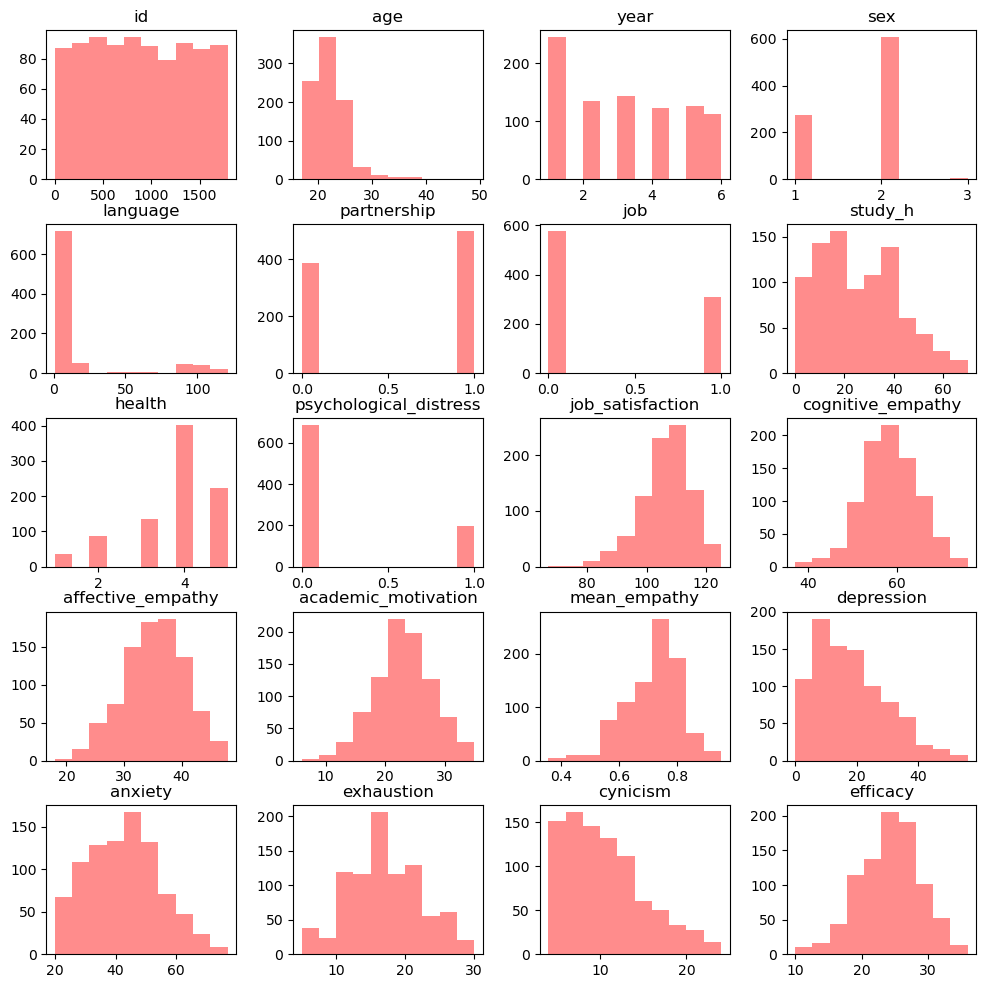

In [7]:
fig = plt.figure(figsize = (12, 12))
ax = fig.gca()
df.hist(ax = ax, alpha = 0.45, color = 'red', grid = False);

We can check if there is any significant correlation between numerical variables: age, year of study, hours of study per week, health, job satisfaction, cognitive empathy, affective empathy, academic motivation, general empathy, depression, anxiety, exhaustion, cynicism, efficacy.

In [8]:
num_var = df[['age', 'year', 'study_h', 'health', 'job_satisfaction', 'cognitive_empathy', 'affective_empathy', 'academic_motivation', 
              'mean_empathy', 'depression', 'anxiety', 'exhaustion', 'cynicism', 'efficacy']]

In [9]:
def correlation_matrix(df):
    '''
    This function calculates correlation coeficients between variables and plots them as correlation matrix
    '''
    corr = df.corr()
    mask = np.triu(corr)

    fig = plt.figure(figsize = (8, 8))
    ax = fig.gca()

    plot = sns.heatmap(corr, annot = True, fmt = '.2f', ax = ax, cbar = False,
                cmap = sns.diverging_palette(210, 20, as_cmap = True),
                mask = mask, 
                vmin=-1, vmax=1, center=0,
                linewidths=3, linecolor = 'white')
    
    return plot

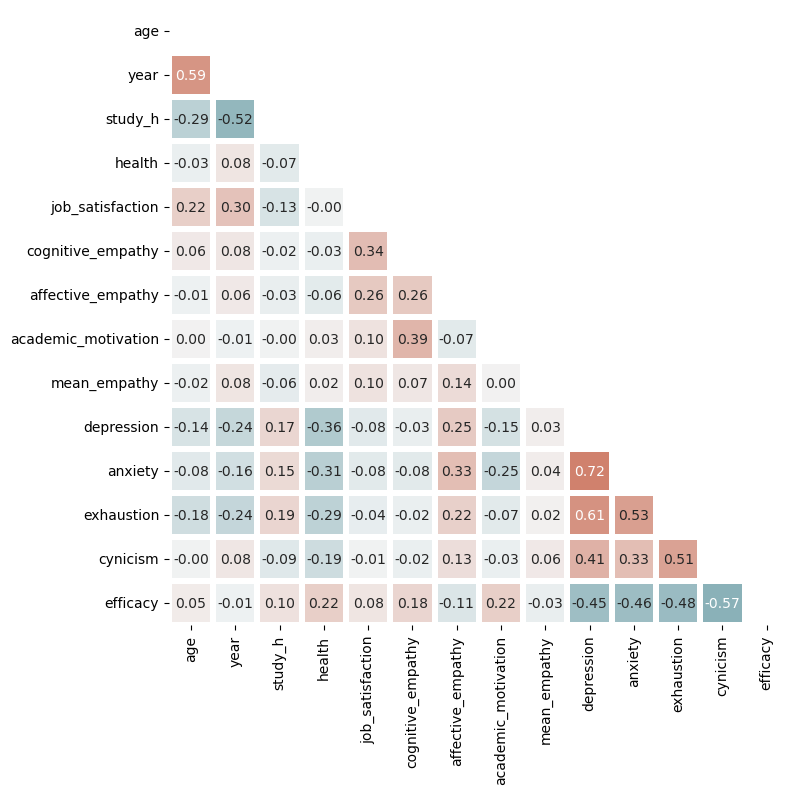

In [10]:
correlation_matrix(num_var);

We can identify most correlated pairs of variables and investigate further how they look by categories.

Anxiety, Exhaustion, Depression are highly positively correlated with each other, which may indicate that they often occure simultaneously. Professional efficacy is negatively correlated mostly with cynicism, exhaustion, depression. Let's further investigate this phenomena. 

#### Burnout, cynicism & efficacy by categories


Sex variable is encoded as follows: 1=Man; 2=Woman; 3=Non-binary

Partnership status variable is encoded as follows: 0=No; 1=Yes

Psychological distress variables is encoded as follows: 0=No; 1=Yes

Mother Tongue variables is encoded as follows: 1=French; 15=German; 20=English; 37=Arab; 51=Basque; 52=Bulgarian; 53=Catalan; 54=Chinese; 59=Korean; 60=Croatian; 62=Danish; 63=Spanish; 82=Estonian; 83=Finnish; 84=Galician; 85=Greek; 86=Hebrew; 87=Hindi; 88=Hungarian; 89=Indonesian; 90=Italian; 92=Japanese; 93=Kazakh; 94=Latvian; 95=Lithuanian; 96=Malay; 98=Dutch; 100=Norwegian; 101=Polish; 102=Portuguese; 104=Romanian; 106=Russian; 108=Serbian; 112=Slovak; 113=Slovenian; 114=Swedish; 116=Czech; 117=Thai; 118=Turkish; 119=Ukrainian; 120=Vietnamese; 121=Other

In [11]:
selected_variables = df.loc[:, ('anxiety', 'exhaustion', 'depression', 'efficacy', 'cynicism', 'sex', 'partnership', 'psychological_distress', 'language')]

In [12]:
selected_variables['sex'] = selected_variables['sex'].map({1: 'man', 2: 'woman', 3: 'non-binary'})
selected_variables['partnership'] = selected_variables['partnership'].map({0: 'Partnership: No', 1: 'Partnership: Yes'})
selected_variables['psychological_distress'] = selected_variables['psychological_distress'].map({0: 'Psychological Distress: No', 
                                                                                                 1: 'Psychological Distress: Yes'})

In [13]:
selected_variables['language'] = selected_variables['language'].map({
    1: 'French', 15: 'German', 20: 'English', 37: 'Arab', 51: 'Basque', 52: 'Bulgarian', 53: 'Catalan', 54: 'Chinese', 59: 'Korean', 60: 'Croatian', 62: 'Danish',63: 'Spanish', 82: 'Estonian', 83: 'Finnish', 84: 'Galician', 85: 'Greek', 86: 'Hebrew', 87: 'Hindi', 88: 'Hungarian', 89: 'Indonesian', 90: 'Italian', 92: 'Japanese', 93: 'Kazakh', 94: 'Latvian', 95: 'Lithuanian', 96: 'Malay', 98: 'Dutch', 100: 'Norwegian', 101: 'Polish', 102: 'Portuguese', 104: 'Romanian', 106: 'Russian', 108: 'Serbian', 112: 'Slovak', 113: 'Slovenian', 114: 'Swedish', 116: 'Czech', 117: 'Thai', 118: 'Turkish', 119: 'Ukrainian', 120: 'Vietnamese', 121: 'Other'}) 


In [14]:
def plot_distributions(df, category):
    """
    This function produces PairGrid plot split by category, with scatterplots in the upper traingle, 
    kernel density estimate (KDE) plots in the lower triangles, and distribution of each variable on the diagonal.
    INPUT:
        df - dataframe with numerical variables to be plotted
        category - string (variable name), name of the column to be used to map categories to different colors
        
    """
    g = sns.PairGrid(df, hue = category, diag_sharey=False,
                         palette = 'deep')

    g.map_upper(sns.scatterplot, s = 80, edgecolor = "white", linewidth = 2.5, alpha = 0.6)
    g.map_lower(sns.kdeplot, shade = True, thresh = 0.05, alpha = 0.45)

    g.map_diag(sns.kdeplot)
    #g.map_diag(sns.histplot, multiple="stack", element="step")

    # Add legend:
    #g.add_legend()
    #g._legend.get_title().set_fontsize(12)
    
    handles = g._legend_data.values()
    labels = g._legend_data.keys()

    g.fig.legend(handles=handles, labels=labels, loc='upper left', ncol=3)
    #g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)
    #g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3)
    g.fig.subplots_adjust(top = 0.96, bottom = 0.08)

    #g.fig.suptitle("Title", y=1.02)

    g.fig.set_size_inches(10,9)

    return g

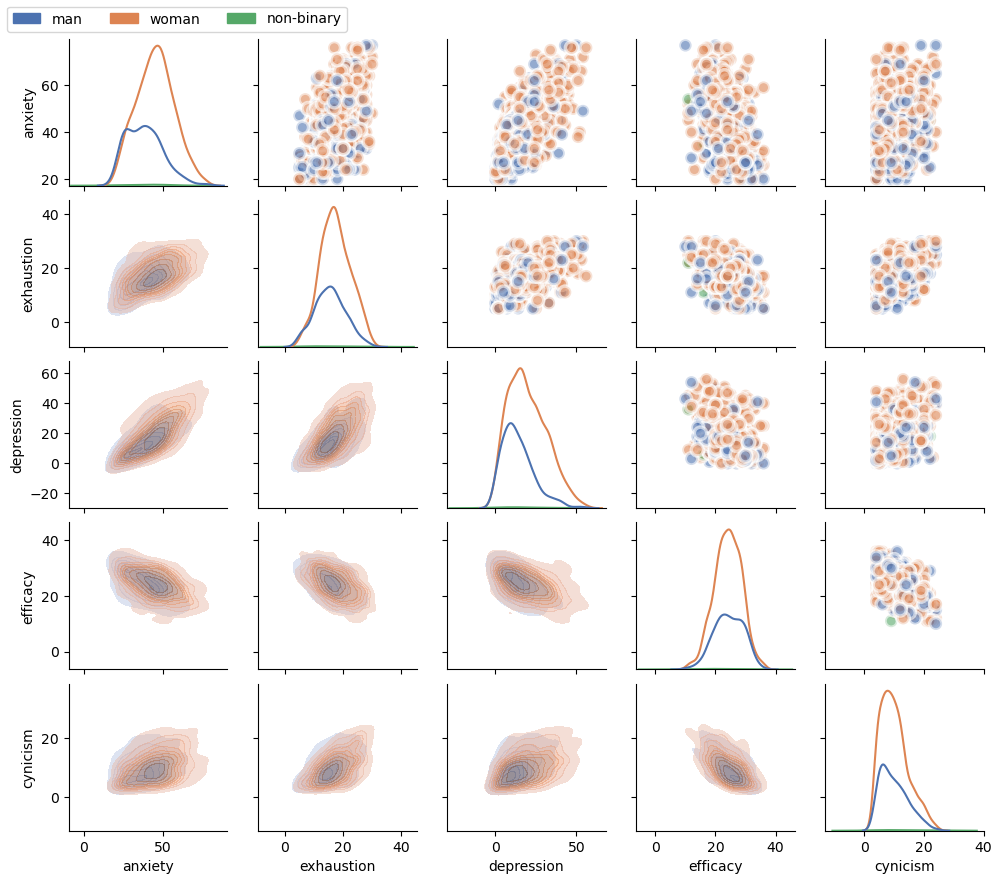

In [15]:
plot_distributions(selected_variables, 'sex');

In [16]:
selected_variables.groupby(by = ['sex'])['depression'].mean()

sex
man           14.003636
non-binary    15.200000
woman         19.910891
Name: depression, dtype: float64

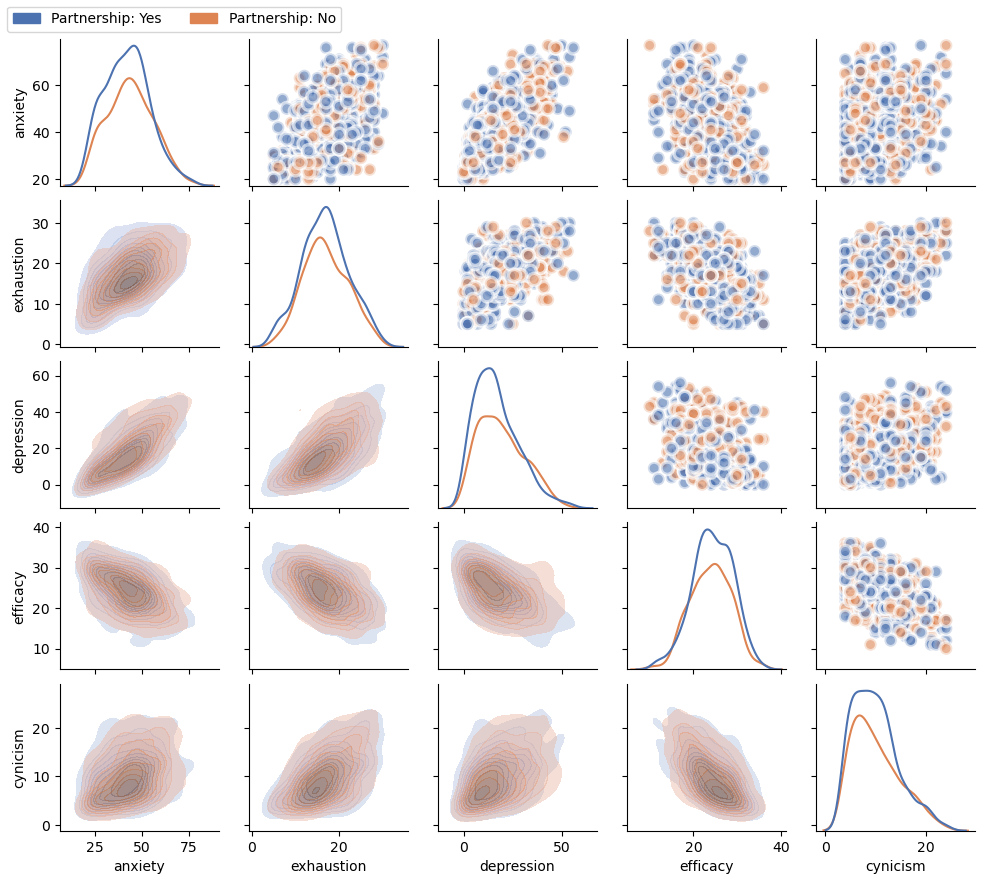

In [17]:
plot_distributions(selected_variables, 'partnership');

In [18]:
selected_variables.groupby(by = ['partnership'])['depression'].mean()

partnership
Partnership: No     19.434109
Partnership: Yes    16.977956
Name: depression, dtype: float64

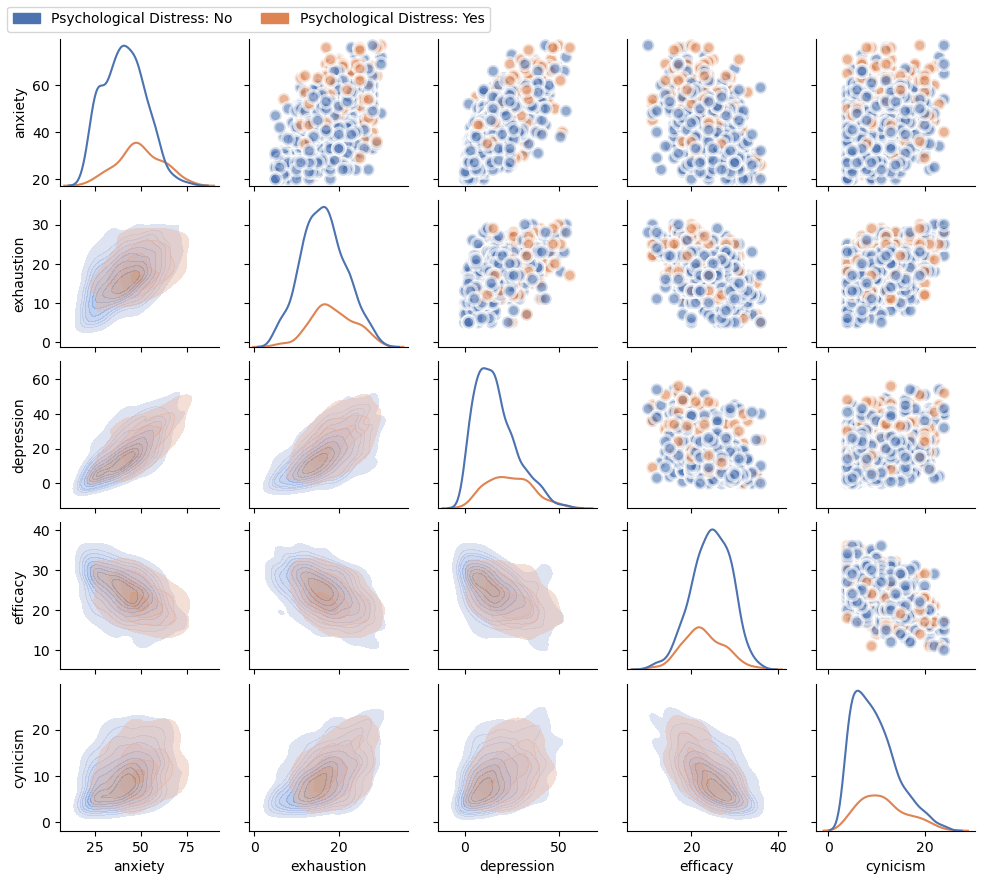

In [19]:
plot_distributions(selected_variables, 'psychological_distress');

We might also want to check if there are any significant differences between categories when it comes to numerical variables related to studies, i.e. academic motivation, hours of study and job satisfaction.

In [20]:
selected_variables = selected_variables.join(df[['academic_motivation', 'study_h', 'job_satisfaction']].set_axis(selected_variables.index))

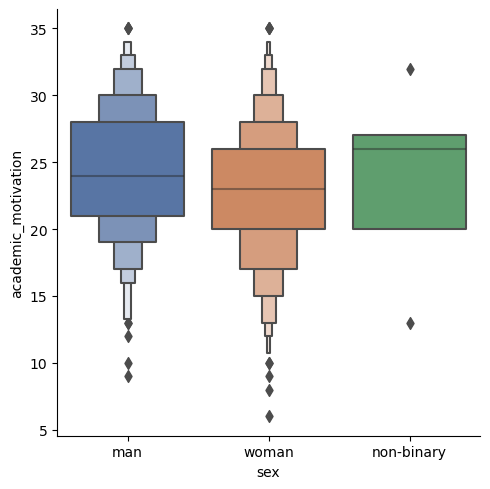

In [21]:
sns.catplot(data = selected_variables, x = 'sex', y = 'academic_motivation', 
            kind = 'boxen', palette = 'deep');

#kind="violin", bw=.25, cut=0, split=True

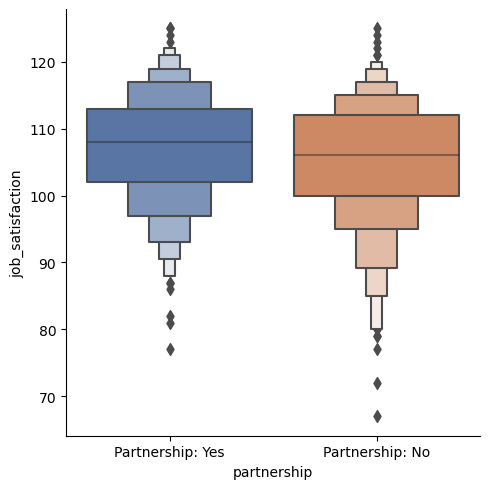

In [22]:
sns.catplot(data = selected_variables, x = 'partnership', y = 'job_satisfaction', 
            kind = 'boxen', palette = 'deep');

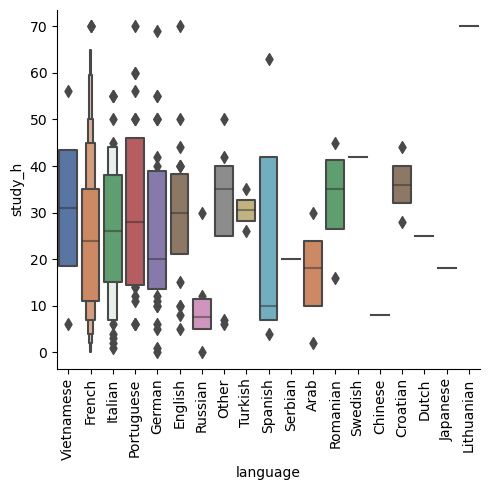

In [23]:
sns.catplot(data = selected_variables, x = 'language', y = 'study_h', 
            kind = 'boxen', palette = 'deep')
plt.xticks(rotation=90)
plt.tight_layout();

## Data Preparation<a id='prepare-data'></a>

In [24]:
clean_df = df.copy()

In [25]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886 entries, 0 to 885
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      886 non-null    int64  
 1   age                     886 non-null    int64  
 2   year                    886 non-null    int64  
 3   sex                     886 non-null    int64  
 4   language                886 non-null    int64  
 5   partnership             886 non-null    int64  
 6   job                     886 non-null    int64  
 7   study_h                 886 non-null    int64  
 8   health                  886 non-null    int64  
 9   psychological_distress  886 non-null    int64  
 10  job_satisfaction        886 non-null    int64  
 11  cognitive_empathy       886 non-null    int64  
 12  affective_empathy       886 non-null    int64  
 13  academic_motivation     886 non-null    int64  
 14  mean_empathy            886 non-null    fl

In [26]:
# check if there are any missing values in any column

clean_df.columns[df.isnull().mean() !=0]

Index([], dtype='object')

In [27]:
# remove unnecessary columns
clean_df = clean_df.drop(['id'], axis = 1)

#### Handling categorical variables

We choose Psychological Distress as our target variable and it's already encoded as binary variable 0-1. Let's

In [28]:
clean_df['psychological_distress'].value_counts()

0    687
1    199
Name: psychological_distress, dtype: int64

In [29]:
clean_df['sex'].value_counts()

2    606
1    275
3      5
Name: sex, dtype: int64

In [30]:
# exclude observations where sex = 3 (limited number of observations)
clean_df = clean_df.loc[df['sex'] != 3]

# encode variable: 0 - man, 1 - woman
clean_df['sex'] = clean_df['sex'].map({1: 0, 2: 1})

In [31]:
df['language'].value_counts()

1      717
90      45
15      31
102     27
20      22
121     13
106      6
63       5
104      4
37       3
60       3
120      2
118      2
108      1
114      1
54       1
98       1
92       1
95       1
Name: language, dtype: int64

In [32]:
# create new column grouping languages different than 1
# French speaker: Yes - 1, No - 0

clean_df['french_speaker'] = clean_df['language'].apply(lambda x: x if x == 1 else 0)

# remove Language column
clean_df = clean_df.drop(['language'], axis = 1)

## Data Modeling<a id='#data-modeling'></a>

We aim to discover what are the factors that might influence psychological distress and if we can predict if a student is going to consult psychiatrist/ psychotherapist.

Our target variable (Psychological Distress) is binary. We test the following algorithms: kNN, to see which one provides best results.

binary target variable -- use logistic regression, kNN, scaling???

In [209]:
y = clean_df['psychological_distress']
X = clean_df.drop(['psychological_distress'], axis = 1)

In [224]:
# scalling the features
scaler = StandardScaler()

#scaler.fit(X)
#X = scaler.transform(X)

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2, stratify = y)

### k-Nearest Neighbors (kNN)

In [226]:
# kNN classifier 
knn = KNeighborsClassifier(n_neighbors = 5)

# fit the classifier
knn.fit(X_train, y_train)

# predict on test data
y_pred_knn = knn.predict(X_test)


In [227]:
# print accuracy
knn.score(X_test, y_test)

0.7547169811320755

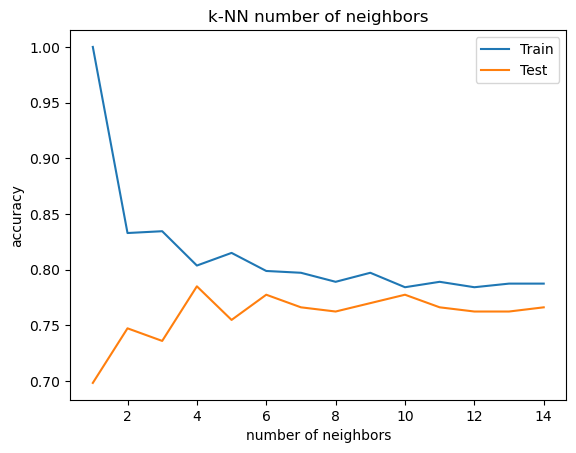

In [228]:
# plot accuracy for different neighbor values
neighbors = np.arange(1, 15)
train_accy = np.empty(len(neighbors)) 
test_accy = np.empty(len(neighbors))

for i, k in enumerate (neighbors):
    # kNN calssifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors = k)
    
    knn.fit(X_train, y_train)
    
    #accuracy on train
    train_accy[i] = knn.score(X_train, y_train)
    
    #accuracy on test
    test_accy[i] = knn.score(X_test, y_test)

plt.title('k-NN number of neighbors')
plt.plot(neighbors, train_accy, label = 'Train')
plt.plot(neighbors, test_accy, label = 'Test')
plt.legend()
plt.xlabel('number of neighbors')
plt.ylabel('accuracy')
plt.show()

In [229]:
# kNN classifier with 4 neighbors
knn = KNeighborsClassifier(n_neighbors = 4)

# fit the classifier
knn.fit(X_train, y_train)

# predict on test data
y_pred_knn = knn.predict(X_test)

In [230]:
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

[[202   3]
 [ 54   6]]
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       205
           1       0.67      0.10      0.17        60

    accuracy                           0.78       265
   macro avg       0.73      0.54      0.53       265
weighted avg       0.76      0.78      0.72       265



In [231]:
f1_score(y_test, y_pred_knn)

0.1739130434782609

### Logistic Regression

In [232]:
log_reg = LogisticRegression(solver='lbfgs', max_iter=400)

#fit to train data
log_reg.fit(X_train, y_train)

#predict labels of test data
y_pred_log = log_reg.predict(X_test)

print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

[[195  10]
 [ 49  11]]
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       205
           1       0.52      0.18      0.27        60

    accuracy                           0.78       265
   macro avg       0.66      0.57      0.57       265
weighted avg       0.74      0.78      0.73       265



### Decision Tree

In [233]:
#Decision Tree classifier
decision_tree = DecisionTreeClassifier(max_depth = 7)

#fit to train data
decision_tree.fit(X_train, y_train)

#predict labels of test data
y_pred_dt = decision_tree.predict(X_test)

print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

[[171  34]
 [ 39  21]]
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       205
           1       0.38      0.35      0.37        60

    accuracy                           0.72       265
   macro avg       0.60      0.59      0.59       265
weighted avg       0.72      0.72      0.72       265



### XGBoost

In [234]:
xgb = XGBClassifier(n_estimators = 2, objective = "binary:logistic")

#fit to train data
xgb.fit(X_train, y_train)

#predict labels of test data
y_pred_xgb = xgb.predict(X_test)

print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


[[187  18]
 [ 42  18]]
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       205
           1       0.50      0.30      0.37        60

    accuracy                           0.77       265
   macro avg       0.66      0.61      0.62       265
weighted avg       0.74      0.77      0.75       265



## Results Evaluation/ Summary<a id='summary'></a>

Further tuning of XGBoost with F1 as scoring function.

Cross validation.

Feature importance.

In [235]:
xgb.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=2, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)>

In [236]:
print(X_train.shape, y_train.shape)

(616, 18) (616,)


In [252]:
# parameters for tuning

params = {'max_depth': [3, 6, 7, 10, 15],
          'eta': [0.001, 0.01, 0.1],
          'max_depth':[2,4,6,8,9], 
          'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [2, 10, 250, 500, 750]
          }


xgb = XGBClassifier(objective = "binary:logistic")

#GridSearchCV
clf = RandomizedSearchCV(estimator = xgb,
                            param_distributions=params, #param_grid=params
                            scoring = 'f1',
                            n_iter = 50,
                            n_jobs=4,
                            # cv = 4,
                            verbose=1, 
                            random_state = 15)

clf.fit(X_train, y_train)

best_params = clf.best_params_

print("Best hyperparameter combination: ", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameter combination:  {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.2, 'eta': 0.001, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.7}


In [238]:
xgb1 = XGBClassifier(objective = "binary:logistic",
                    subsample = 0.5, 
                    n_estimators = 250, 
                    max_depth = 4, 
                    learning_rate = 0.4, 
                    eta = 0.01, 
                    colsample_bytree = 0.6, 
                    colsample_bylevel = 0.5 )

xgb1.fit(X_train, y_train)

#predict labels of test data
y_pred_xgb1 = xgb1.predict(X_test)

print(classification_report(y_test, y_pred_xgb1))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84       205
           1       0.38      0.27      0.31        60

    accuracy                           0.74       265
   macro avg       0.59      0.57      0.58       265
weighted avg       0.71      0.74      0.72       265



In [240]:
# evaluating new model with k-Fold Cross Validation

cv_acc = cross_val_score(estimator = xgb1, X = X_train, y = y_train, cv = 10)

print(cv_acc.mean())
print(cv_acc.std())

0.7420676890534109
0.05722248993498434


In [241]:
cv_f1 = cross_val_score(estimator = xgb1, X = X_train, y = y_train, cv = 10, scoring = 'f1')

print(cv_f1.mean())
print(cv_f1.std())

0.3047857850210791
0.14585007676830047


Feature Importance

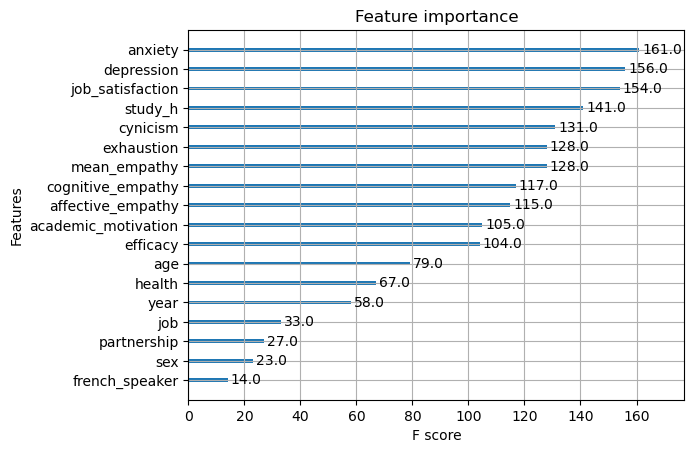

In [242]:
# print feature importance
# xgboost built-in function

plot_importance(xgb1)
plt.show()

In [243]:
# explain model output with SHAP

explainer = shap.Explainer(xgb1, X_train)
shap_values = explainer(X_test, check_additivity = False)

# if we are only interested in SHAP values
#shap_values = explainer.shap_values(X)

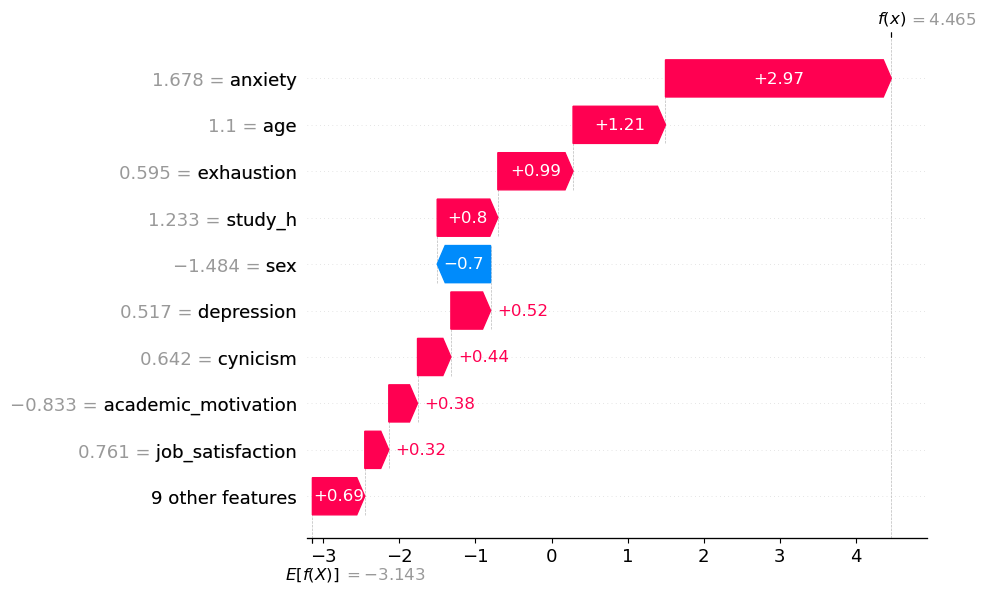

In [244]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

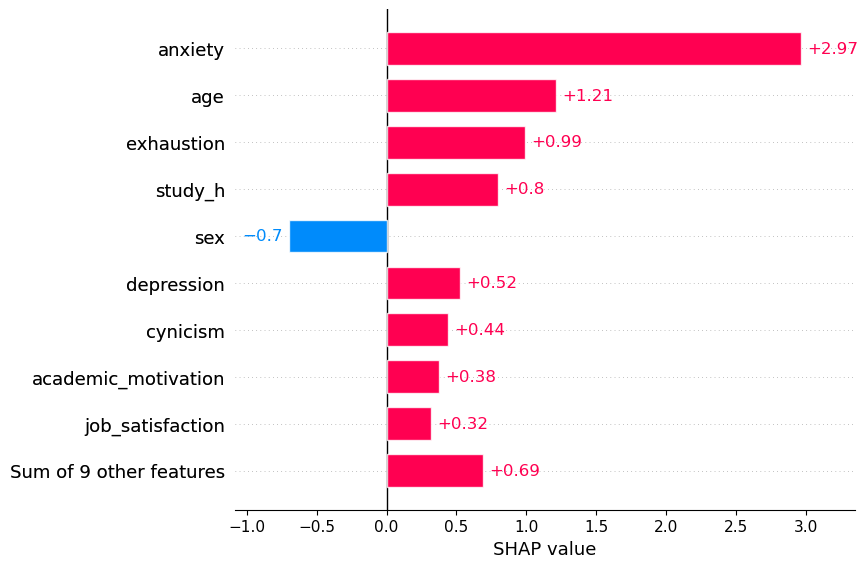

In [245]:
shap.plots.bar(shap_values[0])

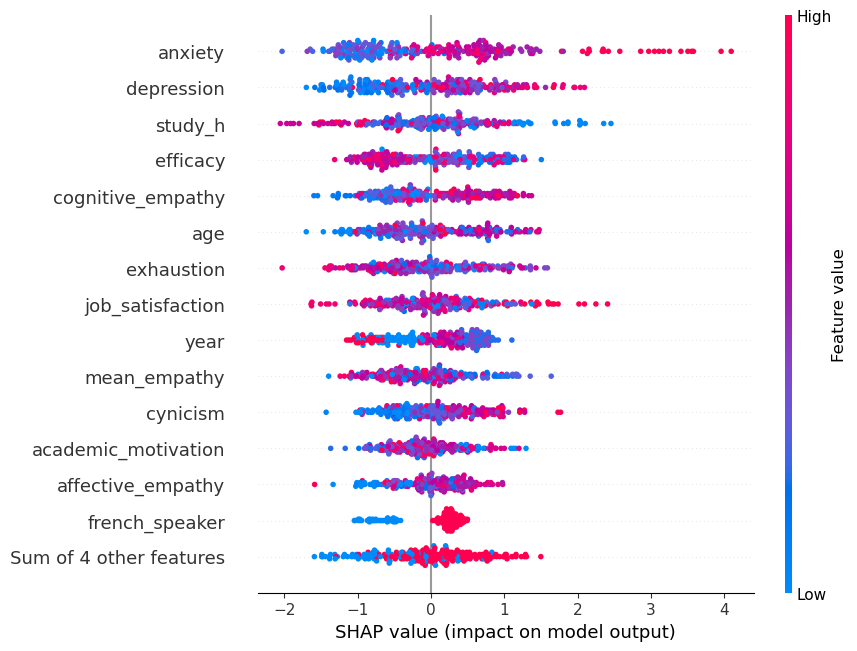

In [248]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display = 15)

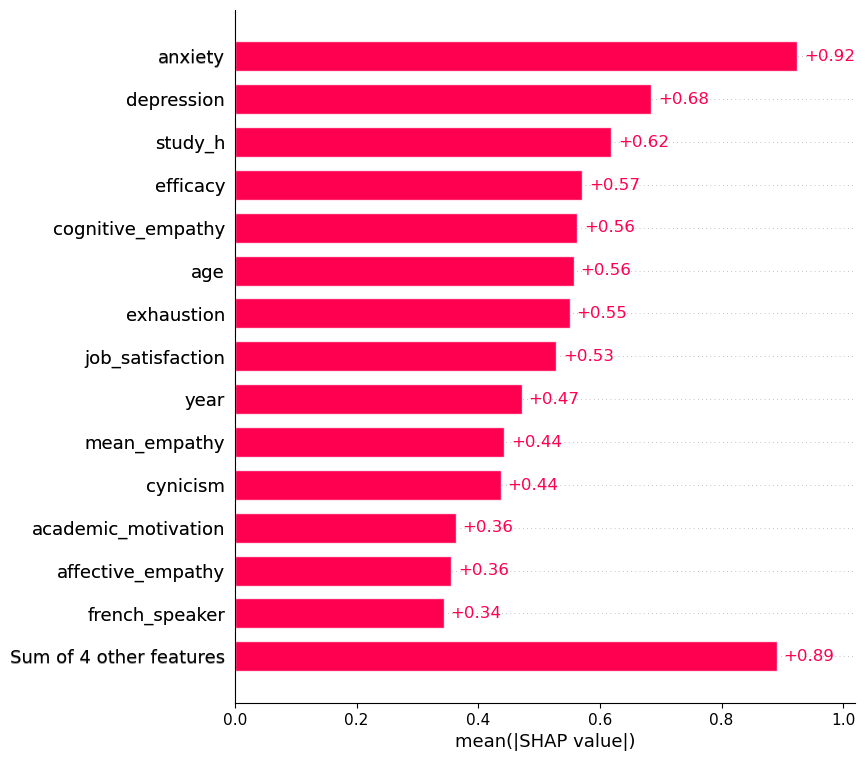

In [249]:
shap.plots.bar(shap_values, max_display = 15)